---
---

<h1><center><ins>Exercise Sheet 11</ins></center></h1>
<h2><center>Numerical Methods <br><br>

---
---

In [40]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, convolve2d, fftconvolve
from astropy.io import fits
import time



## Exercise 1 — Periods in a Variable Star Light Curve & Aliasing

Stars typically exhibit differential rotation (because they are not solid), meaning that their rotational velocity changes as a function of latitude (i.e. rotation around the equator is faster than around the poles typically). 
One way to measure this differential rotation is by tracking darkspots on the surface of the star. The darkspots are areas, where the temperature of the star's surface is locally lower, i.e. the flux output will be lower as well.
Due to the rotation the total flux of the star will be temporarly dimmed, when the darkspot rotates into our line-of-sight. By recording the temporal change of the flux of star is called a Light Curve and we can estimate the stars's rotational velocity from it by assuming Keplerian rotation. (see e.g. https://hoys.space/lightcurve-of-the-week-358/ for an animation).
If there are multiple darkspots at different latitudes present on the star's surface, the recodered Light Curve will be a superposition of multiple sinusoids with different periods. 
Below you find a synthetic *Kepler-like* light curve of a spotted, differentially rotating star. The flux is the sum of three sinusoids plus some noise. The light curve is plotted below.

**A** Compute the one-sided power spectral density (PSD) using a FFT (you can use the build-in functions for FFT from numpy, but code your own function for the PSD) and find the three dominant rotations periods. Use the *find_peaks* function from *scipy.signal*. 
Plot the PSD and the peaks you found. What are the periods you found compared to the true ones?

**B** Compute the Nyquist frequency for the sampling, and **discuss** why this is important.

**C** Repeat **A** by assuming that you recorded the Light Curve only every $m$-th time. Use 8, 16 and 64 for m. What is happening to the PSD and the recovered periods?


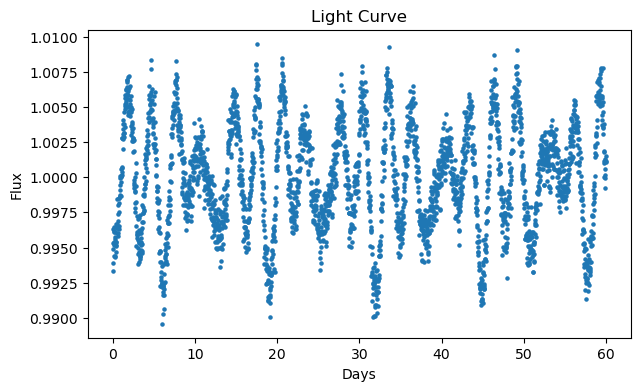

In [41]:

# --- Synthetic light curve ---
rng = np.random.default_rng(42)
# True periods (days)
P_true = np.array([3.2, 2.6, 6.5])
A_true = np.array([0.004, 0.0025, 0.0018])
phi_true = rng.uniform(0, 2*np.pi, size=3)

# Cadence and time base
dt = 30.0 / 60.0 / 24.0  # 30 minutes in days
T = 60.0                 # total baseline in days
t = np.arange(0, T, dt)

# Red-ish noise via filtering white noise
wn = rng.normal(0, 0.001, size=t.size)
# Simple 1D smoothing kernel for colored noise
kernel = np.exp(-0.5*((np.arange(-10,11))/4.0)**2)
kernel /= kernel.sum()
red_noise = np.convolve(wn, kernel, mode='same')

# Signal
signal = np.zeros_like(t)
for A, P, phi in zip(A_true, P_true, phi_true):
    signal += A * np.sin(2*np.pi*t/P + phi)

flux = 1.0 + signal + red_noise + wn

# --- Plot PSD ---
plt.figure(figsize=(7,4))
plt.scatter(t, flux, s=5)  # skip DC on log scale
plt.xlabel("Days")
plt.ylabel("Flux")
plt.title("Light Curve")
plt.show()

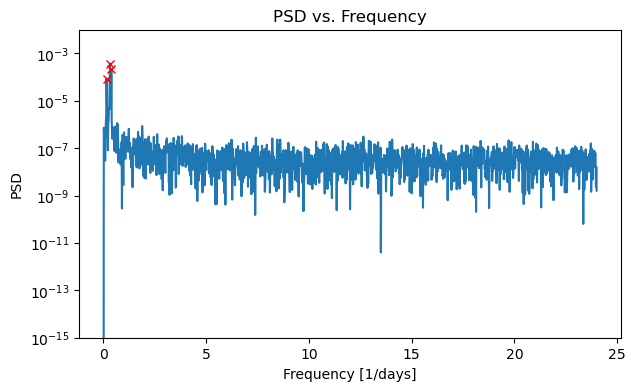

found periods [days]: [2.60869565 3.15789474 6.66666667]
actual periods [days]: [2.6 3.2 6.5]


In [42]:
### A ###

#defining the power spectral density
def psd_func(x, dt):
    x = x - np.mean(x) #the mean is an offset we subtract from the signal to detect the "actual" signal 
    N = len(x)
    fft = np.fft.rfft(x) #rfft for real signals
    psd = (2.0 * dt / N) * np.abs(fft)**2 #due to symmetries H(-f)=H(f)* we take 2*fft², dt normalizes according to timesteps and 1/N normalizes the fft
    freq = np.fft.rfftfreq(N, dt) #this tells us where the information from psd actually lies, i.e. which bins and frequencies
    return freq, psd

freq, psd = psd_func(flux, dt) #applying the function on our signal 

#finding peaks with find_peaks
peaks, _ = find_peaks(psd, height=np.max(psd)*0.05) #with height, i'm making sure only to find "real" peaks and no noise 
freq_peaks = freq[peaks]
periods = 1 / freq_peaks


plt.figure(figsize=(7,4))
plt.plot(freq, psd)
plt.plot(freq_peaks, psd[peaks], "rx")
plt.title('PSD vs. Frequency')
plt.xlabel("Frequency [1/days]")
plt.ylabel("PSD")
plt.yscale("log")
# plt.xlim(0, 25)
plt.ylim(10e-16, 10e-3) #for better readability
plt.show()

print("found periods [days]:", np.sort(periods))
print("actual periods [days]:", np.sort(P_true))


In [43]:
### B ###

f_nyq = 1 / (2*dt) #got the definition from lecture slides
print(f_nyq, '/day')


# What is the Nyquist criterion and why is it important?
# Every frequency above the nyquist critical frequency (in this case 24 Hz) are victim of aliasing. This means that higher frquencies get falsely translated
# into smaller frequencies, the information is lost. In case we have a bandwidth-limited signal smaller than f_nyq, aliasing isn't a problem. 
# Instead, we have to think about the sampling theorem, which tells us that the function is completely determined by its samples.
# Question: here we are limited to f_nyq? aliasing can't occur? or can it? 


24.0 /day


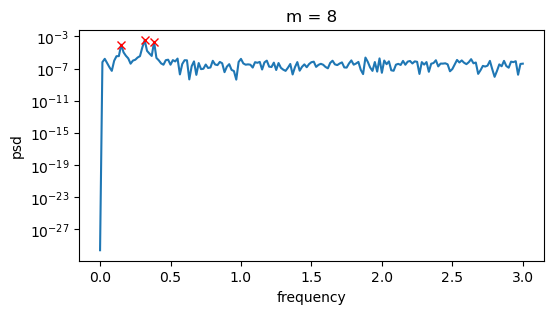

m=8, gefundene Perioden: [2.60869565 3.15789474 6.66666667]


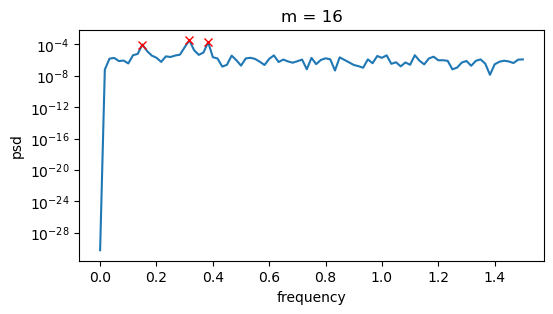

m=16, gefundene Perioden: [2.60869565 3.15789474 6.66666667]


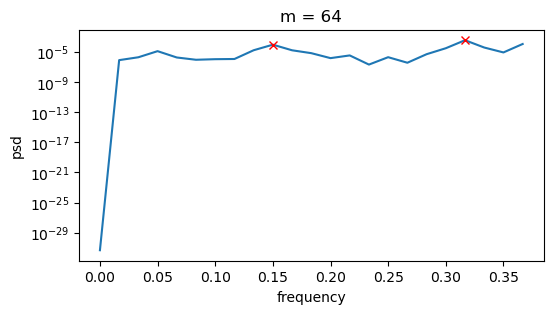

m=64, gefundene Perioden: [3.15789474 6.66666667]


In [44]:
### C ###

def analyze_subsample(m):
    t_m = t[::m] #here we thin out our lightcurve
    flux_m = flux[::m]
    dt_m = dt * m #this leads to an increased time-step (by m)

    freq_m, psd_m = psd_func(flux_m, dt_m) #same steps as above but with subsample m
    peaks_m, _ = find_peaks(psd_m, height=np.max(psd_m)*0.05)

    periods_m = 1 / freq_m[peaks_m]

    plt.figure(figsize=(6,3))
    plt.plot(freq_m, psd_m)
    plt.plot(freq_m[peaks_m], psd_m[peaks_m], "rx")
    plt.title(f"m = {m}")
    plt.yscale("log")
    plt.xlabel("frequency")
    plt.ylabel("psd")
    plt.show()

    print(f"m={m}, gefundene Perioden:", np.sort(periods_m))

for m in [8, 16, 64]: #here we define which steps we want to look at (get from task)
    analyze_subsample(m)


In [45]:
#with increasing m the signal gets more and more flattened which obv makes it harder to actually detect peaks in the signal
#the peak positions are always the same, at m=64 the first peak can't be found anymore though


## Exercise 2 — Radial Velocity from FFT Cross-Correlation of Spectra

Below you see a real spectrum of the elliptical Galaxy NGC3522 taken from the SDSS survey (https://www.sdss.org/). This galaxy has an old stellar population and thus you see deep absorption lines coming from low-mass stars present in the galaxy.

**(A)** Ask your favourite AI to give you the wavelengths in air of the following lines: Ca H & K (H & K comes from the identification that Frauenhofer used when he studied the spectrum of the sun: https://en.wikipedia.org/wiki/Fraunhofer_lines), NaD (sodium doublet) and CaT (calcium triplet). Overplot the wavelength of those lines in the plot of the spectrum of NGC3522. Which formula now can give you very simply the redshift the galaxy?

One popular and perhaps a bit more sphosticated way to measure the redshift (or line-of-sight velocity) of a galaxy is to cross-correlate its spectrum with a template, or model spectrum, which does not contain any noise and where the absorption lines are at their known rest-frame wavelengths.

**(B)** Explain first very simply what cross-correlation is, and how we can measure the redshift from this. Explain also what this has to do with the Fourier Transform.

**(C)** Before you can cross-correlate the observed and modelled spectrum you need to convert the spacing between each recorded wavelength in your spectrum from linear to logarithmic. That means instead of $\lambda_{i+1}-\lambda_i=const.$, you need $\ln\lambda_{i+1}-\ln\lambda_i=const.$. Can you explain why that is? You can ask again your favourite AI if you wish (but please make sure you understand the answer ;). In the code below, you can see that the observed SDSS spectrum is already logarithmically re-binned and for the model spectrum, I am using the function *log_rebin* to convert the wavelength sampling from linear to logarithmic. Hence, there is no further action needed from your side for the next exercise.

**(D)** Implement your own cross correlation function by using build-in FFT methods. Plot the computed cross correlation function versus the lag in km/s. (**Hint**: the pixel spacing in $\AA$ per pixel of both the SDSS and model spectrum are constant in $\ln\lambda$, and the pixel spacing in km/s is stored in the variable *velscale*). Find the redshift you calculate from your cross-correlated signal (**Hint**: the redshift is now: np.exp(**[your solution in km/s]**/c)-1). How does your calculated redshift compare to the one provided by SDSS (**Hint**: it is stored in the variable *redshift_0*) ? For the template spectrum you can use the one provided in the file *Mbi0.30Zp0.40T13.5000_iTp0.00_baseFe.fits*. Below you will find some code to handle the template, which you just need to run.



## Exercise 3 — The power of FFT in 2D image convolutions

In astronomy we are (de)convolving images all the time with, for example, the Point Spread Function (PSF). This would not be possible without the Fast Fourier Transform (FFT) and in this exercise we want to explore that a bit more.

**(A)** To get started write a simple function that returns you an image (2D array) of a simulated star field with infinitely sharp stars (i.e. Delta-function-like stars with no PSF/blurring effects). The function should take the size of the desired image as an argument (make it a square image for simplicity). The stars should be randomly distributed in the field-of-view with random magnitudes. Plot the resulting image for an image size of 128 pixels using *imshow* from *matpotlib*.

**(B)** Now we want to blurr out these image with the PSF (as we would observe them with a telescope). This processes is called *convolution* and the PSF would be our convolution *kernel*, which means that basically for each pixel in your simulated star field image, you apply a blurring, or spreading out of the flux of the stars across neighbouring pixels. The kernel describes in which way this spreading out is done. Write a function for the convolution kernel, i.e. the PSF. Assume that the PSF is Gaussian. Plot the resulting PSF assuming a kernel size of 21 pixels and a FWHM of 2.5 pixels.

**(C)** Doing convolution in image (or pixel) space is not very efficient. Luckly, doing a convolution in Fourier Space becomes easy, since the convolution reduces to a simple multiplication of the Fourer Transform of the image and the kernel. We then arrive back at the real blurred (PSF-convolved) image by calculating the inverse of the Fourier Transform. Implement now your **own algorithm** for FFT and its inverse. Convolve the image from **(A)** with the PSF from **(B)** and plot the new blurred image.

**HINT** Consider the following steps for **(C)**:

*1)* Implement the FFT algorithm for a 1D signal.

*2)* Write a function that calculates the inverse FFT. This function will use the forward FFT (think about the symmetries between discussed in the lecture as your signal only has a real part)

*3)* Calculating the 2D FFT is the same as first calculating 1D FFT along the rows and then along the columns of the image.

*4)* Before you can multiply the FFT of the image and the kernel you need to pad the PSF kernel with zeros to match the image size.

*5)* If you are spending more than 1hr on part **C** alone you may use your favourite AI to help you implement the code, but make sure you can explain/understand the steps that it is doing.

**(D)** Now we want to test the speed of your FFT convolution algorithm versus the **build-in** FFT convolution from *scipy.signal* called *fftconvolve* as well as the naive discrete convolution *convolve2d*. For this write a loop for varying image sizes. Each time double the number of pixels from **(A)**. Do this for times (or less if you have to wait for hours). For each loop time the three convolution functions using *time.time()* (build-in python package). Make a plot of computational time (log-scaled y-axis) vs. number of pixels in the image (x-axis) for all three functions. Who is the winner? How does this compare to the theoretical computational complexity of using FFT and the naive discrete convolution?

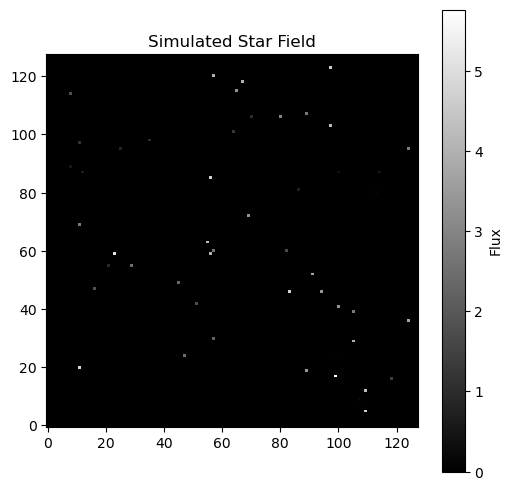

In [54]:
### A ###

def simulate_star_field(size=128, n_stars=50, mag_range=(0, 6), seed=42):
    """
    this function generates a 128 by 128 pixel image
    i can choose the number of stars being generated and the magnitude range
    'seed' is used as an initial value to achieve reproducible results
    
    """
    rng = np.random.default_rng(seed)
    image = np.zeros((size, size)) #defining the size of the image by taking number of pixels as put above
    
    #this gives the random positions for the stars
    x_coords = rng.integers(0, size, size=n_stars)
    y_coords = rng.integers(0, size, size=n_stars)
    
    #this gives random magnitudes in above given range
    fluxes = rng.uniform(mag_range[0], mag_range[1], size=n_stars)
    
    #for a selected pixel, only this one pixel "gets" the flux, these are the delta-function-like stars without psf
    #i use += in case two stars get generated at the same pixel, then the fluxes get added
    for x, y, f in zip(x_coords, y_coords, fluxes):
        image[y, x] += f  
    
    return image


img = simulate_star_field(size=128)
plt.figure(figsize=(6,6))
plt.imshow(img, origin='lower', cmap='gray', interpolation='none') #plotting generated image with imshow
plt.colorbar(label='Flux')
plt.title("Simulated Star Field")
plt.show()


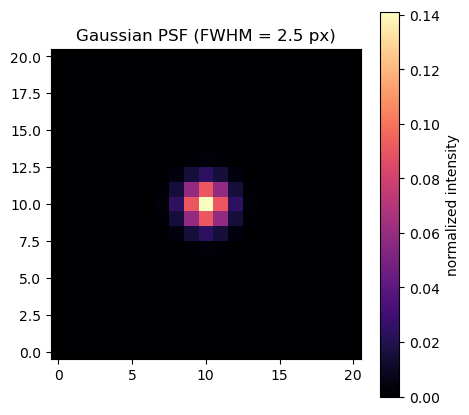

In [55]:
### B ###

def gaussian_psf(size=21, fwhm=2.5):
    """
    this function gives a 2d numpy array
    we set the size and fwhm as given above
    """
    sigma = fwhm / (2*np.sqrt(2*np.log(2))) #FWHM = 2*sqrt(2*ln2)*sigma (Gauss)

    ax = np.arange(-(size//2), size//2 + 1)
    xx, yy = np.meshgrid(ax, ax)

    psf = np.exp(-(xx**2 + yy**2) / (2*sigma**2))
    psf /= psf.sum()  #we normalize this!

    return psf


#the following plots the psf aka the "blurring effect" we apply later on to the simulated star field from task 3A
psf = gaussian_psf(size=21, fwhm=2.5)

plt.figure(figsize=(5,5))
plt.imshow(psf, origin="lower", cmap="magma")
plt.colorbar(label="normalized intensity")
plt.title("Gaussian PSF (FWHM = 2.5 px)")
plt.show()

#when we apply this psf on the star field, every star (pixel) gets smudged as seen below in the plot


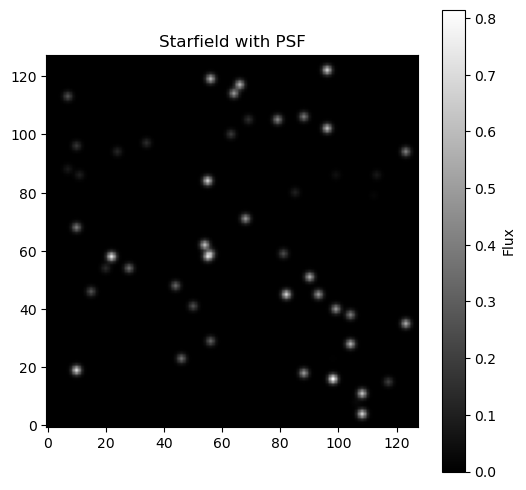

In [56]:
### C ###
## i do two versions of C, one more detailed and one using fft built-in functions
## this is the more detailed version with a bunch of functions

#this only works for 2^n sizes, with 128 okay!
def fft_1d(x):
    x = np.asarray(x, dtype=complex)
    N = x.size
    if N == 1:
        return x
    if N % 2 != 0:
        raise ValueError("Länge muss 2^n sein")

    X_even = fft_1d(x[::2])
    X_odd  = fft_1d(x[1::2])

    factor = np.exp(-2j * np.pi * np.arange(N) / N)
    return np.concatenate([
        X_even + factor[:N//2] * X_odd,
        X_even + factor[N//2:] * X_odd])

#this is our inverse function
def ifft_1d(X):
    X = np.asarray(X, dtype=complex)
    return np.conj(fft_1d(np.conj(X))) / X.size

#now we calculate the 1d-fft twice to get a result as if we did a 2d fft
#i define functions for that

def fft_2d(img): #this takes the 2d image from part A
    temp = np.array([fft_1d(row) for row in img]) #applies fft on rows
    return np.array([fft_1d(col) for col in temp.T]).T #applies fft on columns (temp.T reads columns like rows and .T "converts" it back to column-direction)

#this works the same
def ifft_2d(img_fft):
    temp = np.array([ifft_1d(row) for row in img_fft])
    return np.array([ifft_1d(col) for col in temp.T]).T

#this part is SUPER IMPORTANT, we want to avoid circular convolution
#that's why we want to center the psf and fill the outer pixel with zeros until both osf and image are the same size
def pad_psf(psf, shape):
    padded = np.zeros(shape)
    kh, kw = psf.shape
    padded[:kh, :kw] = psf
    padded = np.roll(padded, -kh//2, axis=0) #"roll" puts psf into the center
    padded = np.roll(padded, -kw//2, axis=1)
    return padded

#we take the image from A and the psf from B
psf_padded = pad_psf(psf, img.shape)

img_fft = fft_2d(img)
psf_fft = fft_2d(psf_padded)

conv_fft = img_fft * psf_fft #this is the actual convolution, we apply the psf to the image in frequency domain (fourier) - here it is only a simple multiplication
blurred = np.real(ifft_2d(conv_fft)) #lastly, we want to transform everything back to time domain, this is what we plot

#now we can plot everything
plt.figure(figsize=(6,6))
plt.imshow(blurred, origin="lower", cmap="gray")
plt.colorbar(label="Flux")
plt.title("Starfield with PSF")
plt.show()


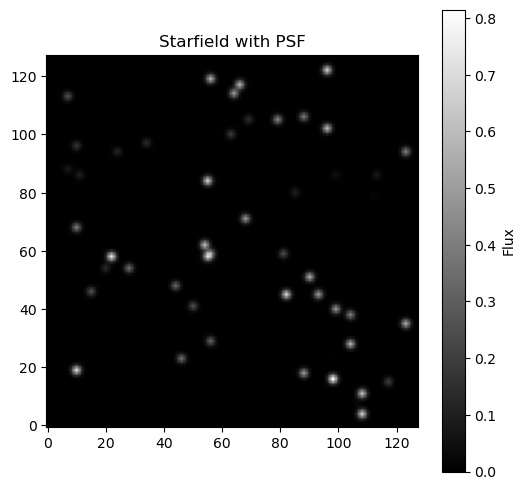

In [ ]:
### C 2.0 ###
##i also want to look at a much shorter version using the fft built-ins from numpy

#this is already multiple steps from above together
#fft2 reads both rows and colums, so this line is equivalent to the function fft_2d
img_fft = np.fft.fft2(img)

#i kept this the same as above, this is the zero-padding to make sure i can apply the psf correctly
def pad_psf(psf, shape):
    padded = np.zeros(shape)
    kh, kw = psf.shape
    padded[:kh, :kw] = psf
    padded = np.roll(padded, -kh//2, axis=0)
    padded = np.roll(padded, -kw//2, axis=1)
    return padded

psf_padded = pad_psf(psf, img.shape)

#we also read the psf (already padded version!!!) in both dimensions with the same numpy function
psf_fft = np.fft.fft2(psf_padded)

#the convolution happens here by multiplying the fft's of the image (A) and the psf(B)
conv_fft = img_fft * psf_fft

#to be able to plot it, we apply the inverse fft again, to bring it back into the time domain
#i use np.real because we only have real signals
blurred = np.real(np.fft.ifft2(conv_fft))

#now we plot
plt.figure(figsize=(6,6))
plt.imshow(blurred, origin="lower", cmap="gray")
plt.colorbar(label="Flux")
plt.title("Starfield with PSF")
plt.show()


Image size: 128x128
Image size: 256x256
Image size: 512x512
Image size: 1024x1024


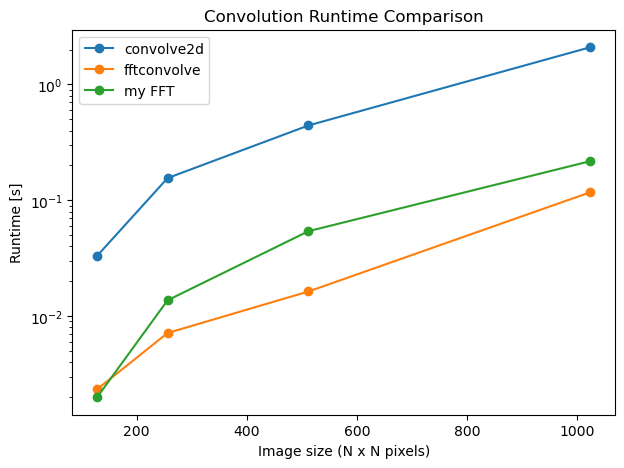

In [62]:
### D ###
#for better accessability, i compress my function from C as follows

def fft_convolve_part_c(img, psf):
    psf_padded = np.zeros_like(img)
    kh, kw = psf.shape
    psf_padded[:kh, :kw] = psf
    psf_padded = np.roll(psf_padded, -kh//2, axis=0)
    psf_padded = np.roll(psf_padded, -kw//2, axis=1)

    return np.real(
        np.fft.ifft2(np.fft.fft2(img) * np.fft.fft2(psf_padded))
    )

#no we get to the timing-loop
sizes = [128, 256, 512, 1024]  #looping four times, with every loop doubling the imagesize
times_naive = []
times_fft_scipy = []
times_fft_manual = []


for N in sizes:
    print(f"Image size: {N}x{N}")

    img = simulate_star_field(size=N)       #takes the image from part A
    psf = gaussian_psf(size=21, fwhm=2.5)   #takes the psf from part B

    #naive discrete concolution
    t0 = time.time()
    convolve2d(img, psf, mode="same")
    times_naive.append(time.time() - t0)

    #build-in fft from scipy
    t0 = time.time()
    fftconvolve(img, psf, mode="same")
    times_fft_scipy.append(time.time() - t0)

    #my fit
    t0 = time.time()
    fft_convolve_part_c(img, psf)
    times_fft_manual.append(time.time() - t0)

#and now we plot, yay
plt.figure(figsize=(7,5))
plt.plot(sizes, times_naive, "o-", label="convolve2d")
plt.plot(sizes, times_fft_scipy, "o-", label="fftconvolve")
plt.plot(sizes, times_fft_manual, "o-", label="my FFT")
plt.yscale("log")
plt.xlabel("Image size (N x N pixels)")
plt.ylabel("Runtime [s]")
plt.legend()
plt.title("Convolution Runtime Comparison")
plt.show()



In [59]:
# convolve2d is the least effective method. It's the slowest for even smaller image sizes and gets SUPER slow with increasing image sizes. Don't use it.
# My FFT performs pretty well for small image sizes but can't keep up with the fftconvolve from scipy for larger image sizes. 
# fftconcolve is, therefore, the most efficient function in that comparison.
# This is also consistent with the complexities given in the lecture slides: 
# For convolve2d (discrete FT), we get O(N^4) (-> lecture slides O(N²) for 1d, but we have 2d).
# For fftconvolve (fast FT), we got O(N²logN) (-> lecture slides O(NlogN) for 1d).
# We see here as well, that fftconvolve is significantly faster, expecially for large N (pixel size). 
